In [27]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy.sparse import diags

In [28]:
%matplotlib inline

# Problem 1

Let $u(x) = sin((x + \pi)^2 - 1)$. Use (1.3) - (1.6) to approximate $\frac{1}{2}
u'' − u'$ at the grid points where $a = 0$, $b = 1$, and $n = 10$. Graph the result.

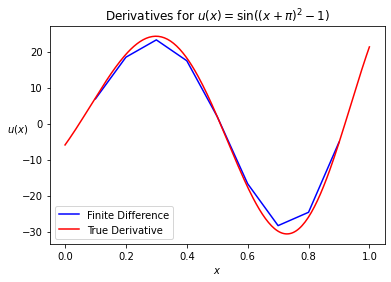

In [29]:
# Initialize the true derivatives for comparison 
u = lambda x: np.sin((x + np.pi)**2 - 1)
Lu = lambda x: 2*((x + np.pi)**2)*np.sin(1 - (x + np.pi)**2) + (-2*x - 2*np.pi + 1)*np.cos(1 - (x + np.pi)**2)
dom = np.linspace(0, 1, 200)

# Initialize values for a, b, n, h, and xs
a, b, n = 0, 1, 10 
h = (b - a)/n 
xs = np.linspace(a, b, n+1)

u_vals = u(xs[1:-1]) # Evaluate u at x values except the end points 
u1_vals, u2_vals = np.zeros(n-1), np.zeros(n-1) # Get the added vectors for equations 1.4 and 1.6
u1_vals[0], u1_vals[-1], u2_vals[0], u2_vals[-1] = -u(xs[0])/(2*h), u(xs[-1])/(2*h), u(xs[0])/(h**2), u(xs[-1])/(h**2)

# Construct the matrices for 1.4 and 1.6
diag1, diag2 = [(n-2)*[1], (n-2)*[-1]], [(n-2)*[1], n*[-2], (n-2)*[1]] 
U1, U2 = (1/(2*h))*diags(diag1, [1, -1]).toarray(), (1/h**2)*diags(diag2, [1, 0, -1]).toarray()

# Get the finite difference estimates
u1, u2 =(U1@u_vals) + u1_vals, (U2@u_vals) + u2_vals  

# Generate plots
plt.plot(xs[1:-1], 0.5*u2 - u1, label = "Finite Difference", color = "blue")
plt.plot(dom, Lu(dom), label = "True Derivative", color = "red")
plt.legend()
plt.title("Derivatives for $u(x)=\sin((x + \pi)^2-1)$")
plt.xlabel("$x$")
plt.ylabel("$u(x)$", rotation = 0)
plt.show()

# Problem 2

Equation (1.7) is the singularly perturbed boundary value problem
\begin{align*}
	&{ } \varepsilon u''(x)-u(x)'= f(x), \quad x \in (0,1), \\
	&{ } u(0) = \alpha, \quad u(1) = \beta.
\end{align*}

Use equation (1.9) to solve the singularly perturbed BVP (1.7) on $[0,1]$ with $\varepsilon = 1/10, f(x) = -1, \alpha=1,$ and $\beta=3$ on a grid with $n=30$ subintervals. Graph the solution. This BVP is called singularly perturbed because of the location of the parameter $\varepsilon$. For $\varepsilon=0$ the ODE has a drastically different character - it then becomes first order, and can no longer support two boundary conditions.

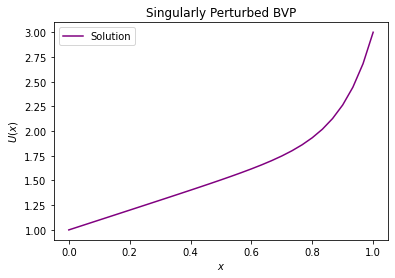

In [30]:
ep, f, alpha, beta, n, a, b = 1/10, -1, 1, 3, 30, 0, 1 # Initialize given variables 
h = (b - a)/n 

xs = np.linspace(a, b, n+1, endpoint = True) # Get x values 
diag = [(n-2)*[ep + (h/2)], (n-1)*[-2*ep], (n-2)*[ep - (h/2)]] # Construct the matrices for 1.9
U1 = (1/(h**2))*diags(diag, [-1, 0, 1]).toarray()
b = -1*np.ones(n-1) # Constsruct right hand side of 1.9
b[0], b[-1] = f - alpha*(ep + (h/2))/(h**2), f - beta*(ep - (h/2))/(h**2)
sol = np.linalg.solve(U1, b) # Solve 1.9
sol = np.concatenate((np.array([alpha]), sol, np.array([beta]))) # Add the boundary conditions 

# Generate plots 
plt.plot(xs, sol, color = "purple", label = "Solution")
plt.xlabel("$x$")
plt.ylabel("$U(x)$")
plt.title("Singularly Perturbed BVP")
plt.legend()
plt.show()

# Problem 3

Implement a function `singular_bvp` to compute the finite difference solution to (1.7).
Using $n = 5 \times 2^0,5 \times 2^1, \dots ,5 \times 2^9$ subintervals, compute 10 approximate solutions.
Use these to visualize the $\mathcal{O}(h^2)$ convergence of the finite difference method from Problem 2 by producing a loglog plot of error against subinterval count; this will be similar to Figure 2, except with $\varepsilon=0.1$. 

To produce the plot, treat the approximation with $n = 5 \times 2^9$ subintervals as the "true solution", and measure the error for the other approximations against it. ote that, since the ratios of numbers of subintervals between approximations are multiples of 2, we can compute the $L_{\infty}$ error for the $n=5 \times 2^j$ approximation by using the `step` argument in the array slicing syntax:

    # best approximation; the vector has length 5*2^9+1
    sol_best = singular_bvp(eps,alpha,beta,f,5*(2**9))

    # approximation with 5*(2^j) intervals; the vector has length 5*2^j+1
    sol_approx = singular_bvp(eps,alpha,beta,f,5*(2**j))

    # approximation error; slicing results in a vector of length 5*2^j+1,
    #    which allows it to be compared
    error = np.max(np.abs(sol_approx - sol_best[::2**(9-j)]))


In [31]:
def singular_bvp(eps,alpha,beta,f,n):
    """
    Solves the singularly perturbed BVP (1.7) on the interval [0,1] using finite differences.
    
    Parameters:
        eps (float): the singular perturbation parameter of the BVP.
        alpha (float): the boundary value of u at x=0.
        beta (float): the boundary value of u at x=1.
        f (callable): the right-hand function of the BVP.
        n (int): the number of subintervals to use in the finite differences method.
        
    Returns:
        ((n+1,) ndarray): the approximated solution to the BVP, including the boundary points.
    """
    h = 1/n # Get h
    xs = np.linspace(0, 1, n+1, endpoint = True) # Get x values 
    
    diag = [(n-2)*[eps + (h/2)], (n-1)*[-2*eps], (n-2)*[eps - (h/2)]] # Construct the matrices for 1.9
    U1 = (1/(h**2))*diags(diag, [-1, 0, 1]).toarray()
    
    b = np.zeros(n-1) # Constsruct right hand side of 1.9
    for i in range(n - 1):
        if i == 0:
            b[i] = f(xs[i+1]) - alpha*(eps + (h/2))/(h**2)
        elif i == n - 2:
            b[i] = f(xs[i+1]) - beta*(eps - (h/2))/(h**2)
        else:
            b[i] = f(xs[i+1])

    sol = np.linalg.solve(U1, b) # Solve 1.9
    sol = np.concatenate((np.array([alpha]), sol, np.array([beta]))) # Add the boundary conditions 
    
    return sol

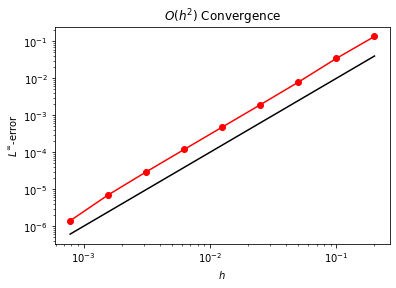

In [100]:
error = [] # Initialize list for errors 
f = lambda x: -1*np.ones_like(x)
eps, alpha, beta = 0.1, 1, 3

# best approximation; the vector has length 5*2^9+1
sol_best = singular_bvp(eps, alpha, beta, f, 5*(2**9))

for j in range(9):
    # approximation with 5*(2^j) intervals; the vector has length 5*2^j+1
    sol_approx = singular_bvp(eps, alpha, beta, f, 5*(2**j))
    
    # approximation error; slicing results in a vector of length 5*2^j+1,
    #    which allows it to be compared
    error.append(np.max(np.abs(sol_approx - sol_best[::2**(9-j)])))
    
hs = np.array([1/(5*2**i) for i in range(9)])
plt.loglog(hs, error, "-o", color = "red")
plt.loglog(hs, hs**2, color = "black")
plt.xlabel("$h$")
plt.ylabel("$L^{\infty}$-error")
plt.title("$O(h^2)$ Convergence")
plt.show()

# Problem 4

Extend your finite difference code to the case of a general second order linear BVP with boundary conditions:

\begin{align*}
	&{ } a_1(x)y''(x) +a_2(x)y'(x)+ a_3(x) y(x) = f(x), \quad x \in (a,b),\\
	&{ } y(a) = \alpha, \quad y(b) = \beta.
\end{align*}

Use your code to solve the boundary value problem

\begin{align*}
	\varepsilon y'(x) - 4(\pi - x^2)y(x) = \cos x, \\
	y(0) = 0, \quad y(\pi/2) = 1,
\end{align*}

for $\varepsilon = 0.1$ on a grid with $n=30$ subintervals. Plot your solution.

In [96]:
def bvp(a,b,alpha,beta,a1,a2,a3,f,n):
    """
    Computes the solution to the BVP:
        
        a1(x)y'' + a2(x)y' + a3(x)y = f
        y(a) = α, y(b) = β
        
    using finite differences.
    
    Parameters:
        a, b (float): the left and right boundary points.
        alpha (float): the boundary value of y at x=a.
        beta (float): the boundary value of y at x=b.
        f (callable): the right-hand function of the BVP.
        a1, a2, a3 (callable): the coefficient functions of the BVP.
        n (int): the number of subintervals to use in the finite differences method.
        
    Returns:
        ((n+1,) ndarray): the approximated solution to the BVP, including the boundary points.
    """
    h = (b - a)/n # Get h
    xs = np.linspace(a, b, n+1) # Get x values 

    diag = [(2*a1(xs[2:-1]) - a2(xs[2:-1])*h)/2, -2*a1(xs[1:-1])+(h**2)*a3(xs[1:-1]), (2*a1(xs[1:-2]) + a2(xs[1:-2])*h)/2]
    DU = (1/(h**2))*diags(diag, [-1, 0, 1]).toarray()
    
    b = np.zeros(n-1) # Constsruct right hand side
    for i in range(n - 1):
        if i == 0:
            b[i] = f(xs[i+1]) - alpha*((2*a1(xs[i+1]) - a2(xs[i+1])*h)/2)/(h**2)
        elif i == n - 2:
            b[i] = f(xs[i+1]) - beta*((2*a1(xs[i+1]) + a2(xs[i+1])*h)/2)/(h**2)
        else:
            b[i] = f(xs[i+1])
    
    sol = np.linalg.solve(DU, b) # Solve
    sol = np.concatenate((np.array([alpha]), sol, np.array([beta]))) # Add the boundary conditions 
    
    return sol

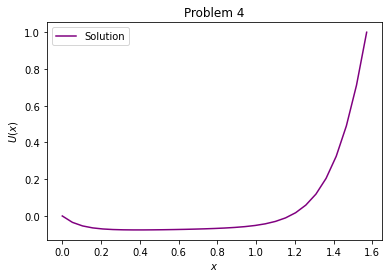

In [101]:
# Initialize values 
eps, n = 0.1, 30
a1, a2, a3, f = lambda x: eps*np.ones_like(x), lambda x: 0*x, lambda x: -4*(np.pi - x**2), lambda x: np.cos(x)
a, b, alpha, beta = 0, np.pi/2, 0, 1
dom = np.linspace(a, b, n+1)

# Solve 
sol = bvp(a, b, alpha, beta, a1, a2, a3, f, n)

# Generate plots 
plt.plot(dom, sol, color = "purple", label = "Solution")
plt.xlabel("$x$")
plt.ylabel("$U(x)$")
plt.title("Problem 4")
plt.legend()
plt.show()

# Problem 5

Numerically solve the boundary value problem

\begin{align*}
	\varepsilon y''(x) + xy'(x) = -\epsilon \pi^2 \cos(\pi x) - \pi x \sin(\pi x), \\
	y(-1) = -2, \quad y(1) = 0,
\end{align*}

for $\epsilon = 0.1, 0.01,$ and $0.001$. Use a grid with $n=150$ subintervals. Plot your solutions.

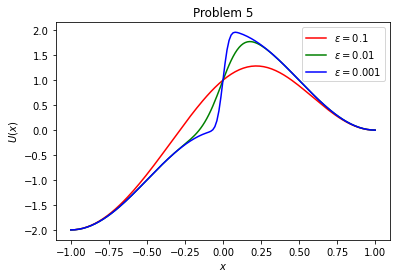

In [102]:
# Initialize values 
eps, n, cols = [0.1, 0.01, 0.001], 150, ["red", "green", "blue"]
a, b, alpha, beta = -1, 1, -2, 0
dom = np.linspace(a, b, n+1)

# Plot solutions 
for val, col in zip(eps, cols):
    a1, a2, a3, f = lambda x: val*np.ones_like(x), lambda x: x, lambda x: 0*x, lambda x: (-val*(np.pi)**2)*np.cos((np.pi)*x) - (np.pi)*x*np.sin((np.pi)*x)
    sol = bvp(a, b, alpha, beta, a1, a2, a3, f, n)
    plt.plot(dom, sol, color = col, label = f"$\epsilon = {val}$")
    
plt.xlabel("$x$")
plt.ylabel("$U(x)$")
plt.title("Problem 5")
plt.legend()
plt.show()



# Problem 6

Numerically solve the boundary value problem

\begin{align*}
	(\varepsilon +x^2)y''(x) + 4xy'(x) + 2y(x) = 0, \\
	y(-1) = 1/(1+\varepsilon), \quad y(1) = 1/(1+\varepsilon),
\end{align*}

for $\epsilon = 0.05$ and $0.02$. Use a grid with $n=150$ subintervals. Plot your solutions.

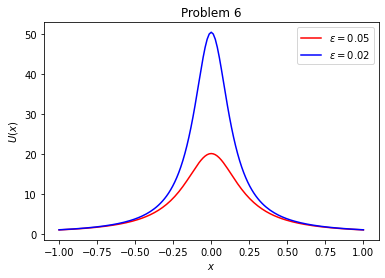

In [103]:
# Initialize values 
eps, n, cols = [0.05, 0.02], 150, ["red", "blue"]
a, b = -1, 1
dom = np.linspace(a, b, n+1)

# Plot solutions 
for val, col in zip(eps, cols):
    a1, a2, a3, f = lambda x: val + x**2, lambda x: 4*x, lambda x: 2*np.ones_like(x), lambda x: 0*x
    alpha, beta = 1/(1 + val), 1/(1 + val)
    sol = bvp(a, b, alpha, beta, a1, a2, a3, f, n)
    plt.plot(dom, sol, color = col, label = f"$\epsilon = {val}$")
    
plt.xlabel("$x$")
plt.ylabel("$U(x)$")
plt.title("Problem 6")
plt.legend()
plt.show()